In [2]:
import sys
sys.path.append('../training')

In [3]:
import models
import keras
import numpy as np

2024-08-23 15:47:57.500855: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 15:47:57.585351: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 15:47:57.673354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 15:47:57.746958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 15:47:57.767807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 15:47:57.902229: I tensorflow/core/platform/cpu_feature_gu

### Load trained model

Using: https://wandb.ai/alessandro-ruzza/dbnets2.0.0/runs/edmtn20d/overview

In [4]:
loaded_model = keras.saving.load_model('new_test/new_test.1.keras', compile=True, custom_objects = {f'mse_of_output_{i}': models.separate_mse(i) for i in range(6)})

/home/aleruzza/UNI/SCIENCE/DBNets/tool_mainversion_git/DBNets/keras3_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Load test set

In [5]:
from config import configs
params = configs[0]
params['times'] = [500,1000,1500]
data = {}
for t in params['times']:
    data[f"time{t}"] = np.load(
        f'../training/{params["data_path"]}/{t}/data.npy', allow_pickle=True
    ).item()

In [6]:
from config import normalize_input_data
import tensorflow as tf
fold = 1

train_inp = np.concatenate(
            [
                np.expand_dims(data[f"time{t}"][f"inp_train{fold}"], axis=3)
                for t in params["times"]
            ],
            axis=0,
        )
train_inp = normalize_input_data(train_inp)

target_train = np.concatenate(
    [
        # this is necessary because labels have been wrongly packed
        np.concatenate(
            [
                data[f"time{t}"][f"targ_train{fold}"].reshape(-1, 6)[i::3]
                for i in range(3)
            ]
        )
        for t in params["times"]
    ],
    axis=0,
)
test_inp = np.concatenate(
    [
        np.expand_dims(data[f"time{t}"][f"inp_test{fold}"], axis=3)
        for t in params["times"]
    ],
    axis=0,
)
test_inp = normalize_input_data(test_inp)

target_test = np.concatenate(
    [data[f"time{t}"][f"targ_test{fold}"] for t in params["times"]], axis=0
)




In [7]:
del data

## Results without MC dropout + MC augmentation

In [129]:
testing_resolutions=[0, 0.05, 0.1, 0.15]
def test(model, data, testing_resolutions=[0, 0.05, 0.1, 0.15], mcdrop=0):
    results = {}
    # Unpack the data
    x, y = data
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)
    results["loss"] = 0
    if mcdrop>1:
        y = np.repeat(y, mcdrop, axis=0)
    for res in testing_resolutions:
        # generate convolved testing images
        sigma = tf.ones(shape=(tf.shape(x)[0], 1)) * res
        smoothed_x = model.get_smoothing_layer().smooth(x, sigma)
        results[f'smoothed_img_r{res}'] = smoothed_x
        if mcdrop>1:
            sigma = np.repeat(sigma, mcdrop, axis=0)
            smoothed_x = np.repeat(smoothed_x, mcdrop, axis=0)
        # Compute predictions
        y_pred = model(smoothed_x, res=sigma, training=mcdrop>1, no_smooth=True)
        results[f'y_pred_r{res}'] = y_pred
        # Updates the metrics tracking the loss
        loss = model.compute_loss(y=y, y_pred=y_pred)
        # Update the metrics.
        for metric in model.metrics:
            if metric.name != "loss":
                metric.update_state(y, y_pred)
                for name, val in metric.result().items():
                    results[f"{name}_r{res}"] = val
            else:
                metric.update_state(loss)
                results[f"{metric.name}_r{res}"] = metric.result()
                results["loss"] += metric.result() / len(testing_resolutions)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        for m in model.metrics:
            m.reset_state()
    return results

In [10]:
results = test(loaded_model, (test_inp, target_test), testing_resolutions=testing_resolutions)

NameError: name 'testing_resolutions' is not defined

### Plot results

In [18]:
import os
folder = 'plots/edmtn20d'
if not os.path.exists(folder):
    os.mkdir(folder)

In [25]:
results.keys()

dict_keys(['loss', 'y_pred_r0', 'loss_r0', 'mse_of_output_0_r0', 'mse_of_output_1_r0', 'mse_of_output_2_r0', 'mse_of_output_3_r0', 'mse_of_output_4_r0', 'mse_of_output_5_r0', 'y_pred_r0.05', 'loss_r0.05', 'mse_of_output_0_r0.05', 'mse_of_output_1_r0.05', 'mse_of_output_2_r0.05', 'mse_of_output_3_r0.05', 'mse_of_output_4_r0.05', 'mse_of_output_5_r0.05', 'y_pred_r0.1', 'loss_r0.1', 'mse_of_output_0_r0.1', 'mse_of_output_1_r0.1', 'mse_of_output_2_r0.1', 'mse_of_output_3_r0.1', 'mse_of_output_4_r0.1', 'mse_of_output_5_r0.1', 'y_pred_r0.15', 'loss_r0.15', 'mse_of_output_0_r0.15', 'mse_of_output_1_r0.15', 'mse_of_output_2_r0.15', 'mse_of_output_3_r0.15', 'mse_of_output_4_r0.15', 'mse_of_output_5_r0.15'])

In [16]:
from sklearn.metrics import r2_score

In [43]:
from matplotlib import testing
import matplotlib.pyplot as plt
from train_multip import __LABELS__


for res in testing_resolutions:
    fig, axs = plt.subplots(2,3, figsize=(9.5,6))
    axs = axs.flatten()
    for v in range(6):
        axs[v].scatter(target_test[:,v], results[f'y_pred_r{res}'][:, v], marker='.', color='black', s=5)
        axs[v].set_xlabel('Target')
        axs[v].set_ylabel('Prediction')
        axs[v].set_xlim(-1.1,1.1)
        axs[v].set_ylim(-1.1,1.1)
        r2score = r2_score(target_test[:, v], results[f'y_pred_r{res}'][:, v].numpy().astype(float))
        axs[v].set_title(f'{__LABELS__[v]}\nmse: {results[f"mse_of_output_{v}_r{res}"]:.2f}, r2: {r2score:.2f}')
        axs[v].plot([-1,1], [-1,1], color='red')
        results[f'r2_of_output_{v}_r{res}'] = r2score
    plt.tight_layout()
    plt.savefig(f'{folder}/scatter_r{res}.png', dpi=500, bbox_inches='tight')
    plt.clf()

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

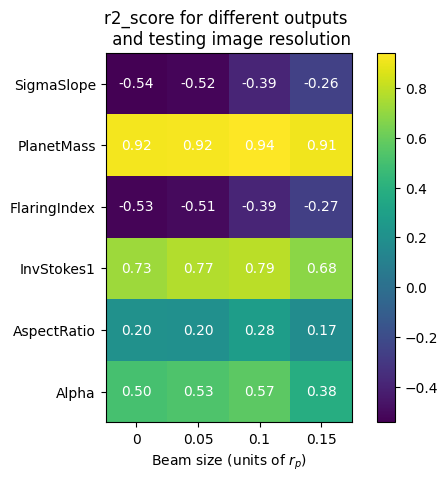

In [80]:
r2_scores = [results[f'r2_of_output_{v}_r{res}'] for v in range(6) for res in testing_resolutions]
plt.pcolormesh(range(4), range(6), np.array(r2_scores).reshape(6,4), shading='nearest')
plt.colorbar()
plt.title('r2_score for different outputs \n and testing image resolution')
plt.yticks(range(6),labels=__LABELS__)
plt.xticks(range(4), labels=testing_resolutions)
plt.xlabel('Beam size (units of $r_p$)')
plt.gca().set_aspect(1)

for i in range(6*4):
    plt.text(i%4, int(i/4), [f'{r2:.2f}' for r2 in r2_scores][i], ha='center', va='center', color='white')
plt.savefig(f'{folder}/r2_resvslab.png', dpi=500, bbox_inches='tight')

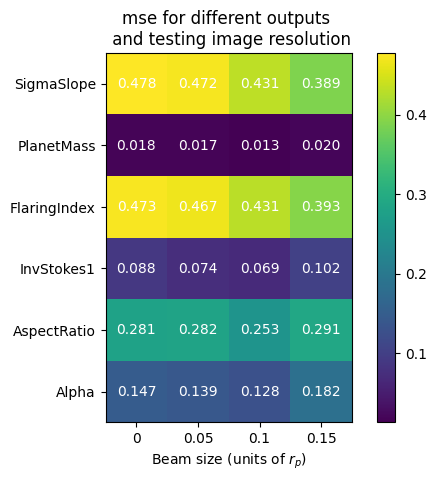

In [82]:
mse_list = [results[f'mse_of_output_{v}_r{res}'] for v in range(6) for res in testing_resolutions]
plt.pcolormesh(range(4), range(6), np.array(mse_list).reshape(6,4), shading='nearest')
plt.colorbar()
plt.title('mse for different outputs \n and testing image resolution')
plt.yticks(range(6),labels=__LABELS__)
plt.xticks(range(4), labels=testing_resolutions)
plt.xlabel('Beam size (units of $r_p$)')
plt.gca().set_aspect(1)
for i in range(6*4):
    plt.text(i%4, int(i/4), [f'{mse:.3f}' for mse in mse_list][i], ha='center', va='center', color='white')
plt.savefig(f'{folder}/mse_resvslab.png', dpi=500, bbox_inches='tight')

# With MC dropout

In [12]:
results_mc = test(loaded_model, (test_inp[:100], target_test[:100]), testing_resolutions=testing_resolutions,mcdrop=10)

In [25]:
results_mc[f'y_pred_r0'].numpy()

array([[-0.66804236, -0.4045554 ,  0.21290077, -0.6292991 , -0.45992622,
        -0.643236  ],
       [-0.62006485, -0.42736086,  0.36142185, -0.48200113, -0.20720391,
        -0.4409688 ],
       [-0.6962109 , -0.60756576,  0.5244782 , -0.3271039 , -0.31504768,
        -0.41281506],
       ...,
       [-0.23838328,  0.47947845, -0.62890744, -0.37300792,  0.67907923,
        -0.4114383 ],
       [-0.44199058,  0.09594712, -0.29702193, -0.18901347,  0.5894261 ,
        -0.14386448],
       [-0.2910311 ,  0.06044991, -0.07594214, -0.1958047 ,  0.59401256,
        -0.20362037]], dtype=float32)

array([[[-0.66804236, -0.4045554 ,  0.21290077, -0.6292991 ,
         -0.45992622, -0.643236  ],
        [-0.62006485, -0.42736086,  0.36142185, -0.48200113,
         -0.20720391, -0.4409688 ],
        [-0.6962109 , -0.60756576,  0.5244782 , -0.3271039 ,
         -0.31504768, -0.41281506],
        ...,
        [-0.82671165, -0.59627736,  0.54751456, -0.41977984,
         -0.53747857, -0.49629033],
        [-0.7909708 , -0.55686206,  0.2914372 , -0.6385195 ,
         -0.52543676, -0.67246413],
        [-0.717255  , -0.43448102,  0.29484037, -0.43220612,
         -0.34509954, -0.44488335]],

       [[-0.9234469 ,  0.97007865,  0.52192575, -0.6669633 ,
          0.37228763, -0.58256924],
        [-0.8771123 ,  0.889297  ,  0.45771545, -0.36801976,
          0.3132785 , -0.2986514 ],
        [-0.8287665 ,  0.91632354,  0.5576318 , -0.662776  ,
          0.49285722, -0.67780423],
        ...,
        [-0.87411606,  0.7536185 ,  0.6243389 , -0.28373352,
          0.35211003, -0.27341756],
  

In [19]:
from matplotlib import testing
import matplotlib.pyplot as plt
from train_multip import __LABELS__


for res in testing_resolutions:
    fig, axs = plt.subplots(2,3, figsize=(9.5,6))
    axs = axs.flatten()
    for v in range(6):
        target = np.repeat(target_test[:100,v], 10, axis=0)
        axs[v].scatter(target, results_mc[f'y_pred_r{res}'][:, v], marker='.', color='black', s=5)
        axs[v].set_xlabel('Target')
        axs[v].set_ylabel('Prediction')
        axs[v].set_xlim(-1.1,1.1)
        axs[v].set_ylim(-1.1,1.1)
        r2score = r2_score(target, results_mc[f'y_pred_r{res}'][:, v].numpy().astype(float))
        axs[v].set_title(f'{__LABELS__[v]}\nmse: {results_mc[f"mse_of_output_{v}_r{res}"]:.2f}, r2: {r2score:.2f}')
        axs[v].plot([-1,1], [-1,1], color='red')
        results_mc[f'r2_of_output_{v}_r{res}'] = r2score
    plt.tight_layout()
    plt.savefig(f'{folder}/scatter_r{res}_mc.png', dpi=500, bbox_inches='tight')
    plt.clf()

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

In [36]:
   
    
from matplotlib import testing
import matplotlib.pyplot as plt
from train_multip import __LABELS__


for res in testing_resolutions:
    r = results_mc[f'y_pred_r{res}'].numpy().reshape(-1,10,6)
    means = (r.max(axis=1)+r.min(axis=1))/2
    std = (r.max(axis=1)-r.min(axis=1))/2
    fig, axs = plt.subplots(2,3, figsize=(9.5,6))
    axs = axs.flatten()
    for v in range(6):
        target = target_test[:100,v]
        axs[v].errorbar(target, means[:,v], yerr=std[:,v], fmt='.', color='black')
        axs[v].set_xlabel('Target')
        axs[v].set_ylabel('Prediction')
        axs[v].set_xlim(-1.1,1.1)
        axs[v].set_ylim(-1.1,1.1)
        #r2score = r2_score(target, results_mc[f'y_pred_r{res}'][:, v].numpy().astype(float))
        axs[v].set_title(f'{__LABELS__[v]}\nmse: {results_mc[f"mse_of_output_{v}_r{res}"]:.2f}, r2: {r2score:.2f}')
        axs[v].plot([-1,1], [-1,1], color='red')
        results_mc[f'r2_of_output_{v}_r{res}'] = r2score
    plt.tight_layout()
    plt.savefig(f'{folder}/scatter_r{res}_mc_ebar.png', dpi=500, bbox_inches='tight')
    plt.clf()

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

In [40]:
for res in testing_resolutions:
    r = results_mc[f'y_pred_r{res}'].numpy().reshape(-1,10,6)
    means = (r.max(axis=1)+r.min(axis=1))/2
    std = (r.max(axis=1)-r.min(axis=1))/2
    fig, axs = plt.subplots(2,3, figsize=(9.5,6))
    axs = axs.flatten()
    for v in range(6):
        target = target_test[:100,v]
        stderr =(target-means[:,v])/std[:,v]
        axs[v].hist( stderr, color='black', histtype='step', hatch='////')
        axs[v].set_xlabel('Standardized errors')
        axs[v].set_ylabel('#')
        
        #r2score = r2_score(target, results_mc[f'y_pred_r{res}'][:, v].numpy().astype(float))
        axs[v].set_title(f'{__LABELS__[v]}\n mean: {stderr.mean():.2f}, std: {stderr.mean():.2f}')
    plt.tight_layout()
    plt.savefig(f'{folder}/hist_r{res}_mc.png', dpi=500, bbox_inches='tight')
    plt.clf()

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

<Figure size 950x600 with 0 Axes>

In [42]:
test_id = 10

In [51]:
result = test(loaded_model, (test_inp[test_id].reshape(1,128,128,1), target_test[test_id].reshape(1,6)), testing_resolutions=testing_resolutions,mcdrop=1000)

In [46]:
result['y_pred_r0'][4]

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-3.8522565e-01, -3.3542264e-01, -3.8702080e-01, -2.9718317e-04,
       -9.8583795e-02,  5.4336913e-02], dtype=float32)>

In [48]:
__LABELS__

['Alpha',
 'AspectRatio',
 'InvStokes1',
 'FlaringIndex',
 'PlanetMass',
 'SigmaSlope']

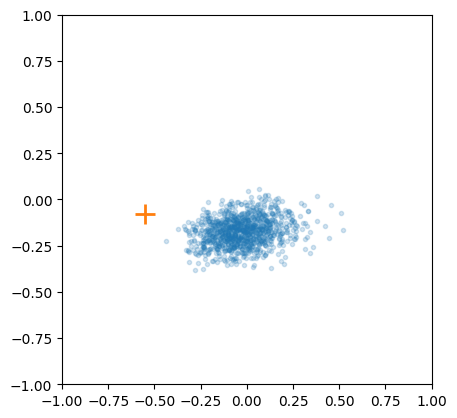

In [77]:
plt.scatter(result['y_pred_r0'][:,5], result['y_pred_r0'][:,4], marker='.', alpha=0.2)
plt.scatter(target_test[test_id][5], target_test[test_id][4], marker='+', s=200, linewidth=2)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.gca().set_aspect(1)

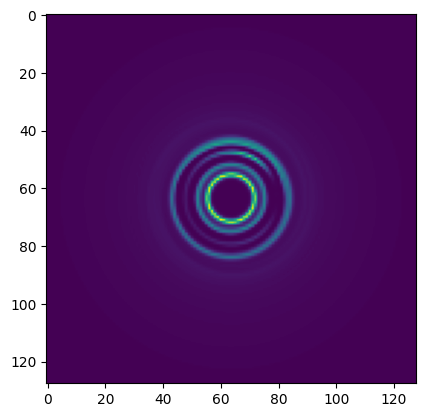

In [55]:
plt.imshow(test_inp[test_id])

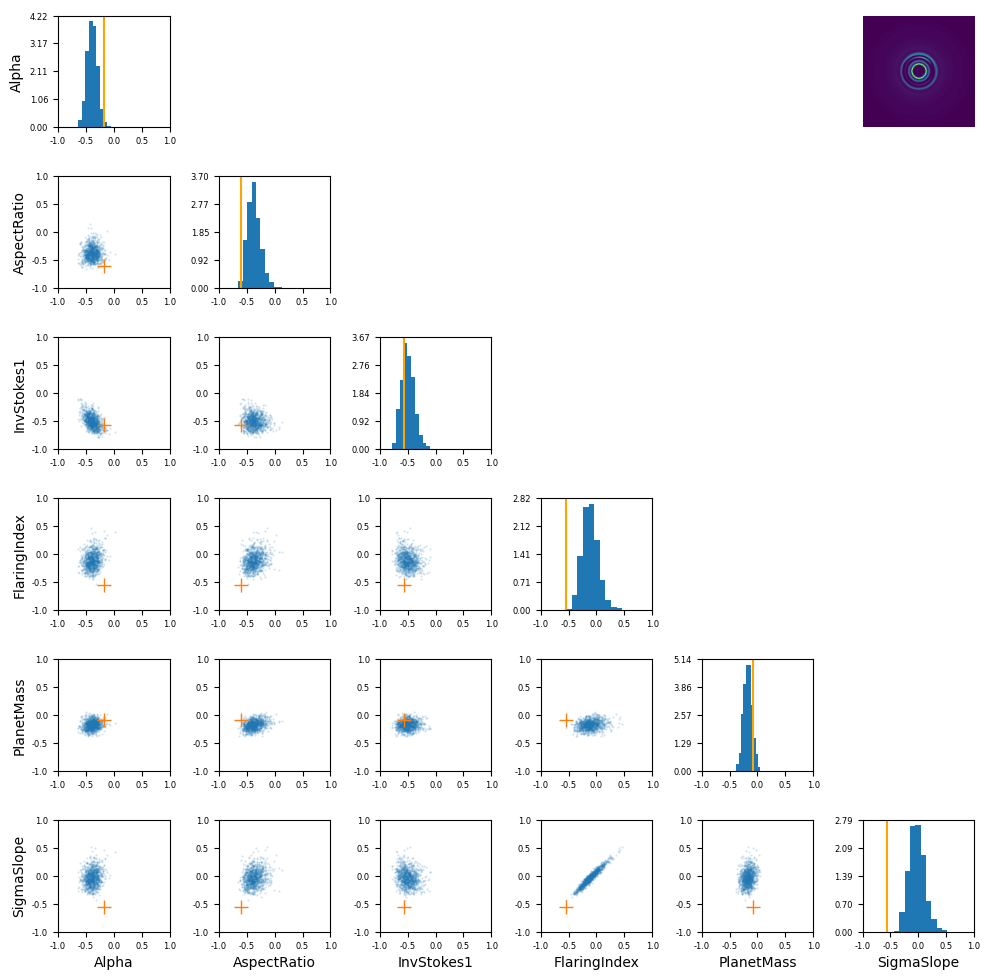

In [128]:
# correlations
test_id = 10
result = test(loaded_model, (test_inp[test_id].reshape(1,128,128,1), target_test[test_id].reshape(1,6)), testing_resolutions=testing_resolutions,mcdrop=1000)
fig, axs = plt.subplots(6,6, figsize=(10,10))
for res in testing_resolutions:
    for i in range(6):
        for j in range(6):
            if j<i:
                axs[i][j].scatter(result[f'y_pred_r{res}'][:,j], result[f'y_pred_r{res}'][:,i], marker='.', s=1, alpha=0.2)
                axs[i][j].scatter(target_test[test_id][j], target_test[test_id][i], marker='+', s=100, linewidth=1)
                axs[i][j].set_xlim(-1,1)
                axs[i][j].set_ylim(-1,1)
                axs[i][j].set_aspect(1)
                axs[i][j].set_yticks(np.linspace(-1,1,5))
                axs[i][j].set_xticks(np.linspace(-1,1,5))
                axs[i][j].set_yticklabels(np.linspace(-1,1,5), size=6)
                axs[i][j].set_xticklabels(np.linspace(-1,1,5), size=6)
            if j==0:
                axs[i][j].set_ylabel(__LABELS__[i])
            if i==5:
                axs[i][j].set_xlabel(__LABELS__[j])
            if j==i:
                axs[i][j].hist(result[f'y_pred_r{res}'][:,j], density=True)
                axs[i][j].axvline(target_test[test_id][i], color='orange')
                axs[i][j].set_xlim(-1,1)
                axs[i][j].set_aspect(2/axs[i][j].get_ylim()[-1])
                axs[i][j].set_yticks(np.linspace(*axs[i][j].get_ylim(),5))
                axs[i][j].set_xticks(np.linspace(-1,1,5))
                axs[i][j].set_yticklabels([f'{s:.2f}' for s in np.linspace(*axs[i][j].get_ylim(),5)], size=6)
                axs[i][j].set_xticklabels(np.linspace(-1,1,5), size=6)
            if j>i:
                axs[i][j].axis('off')
                if i==0 and j==5:
                    axs[i][j].imshow(results[f'smoothed_img_r{res}'])
                
    plt.tight_layout()

In [65]:
plt.gca().set_aspect

Object `set_aspect` not found.


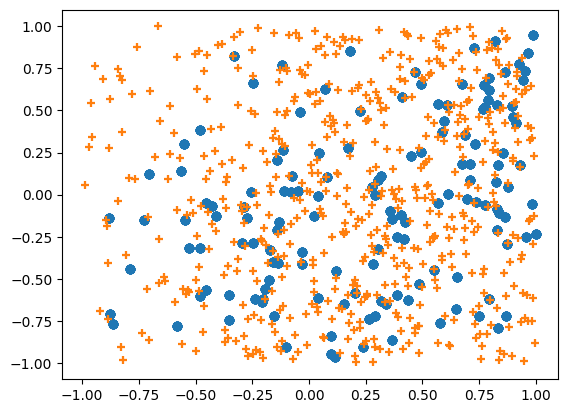

In [ ]:
plt.scatter(results_t_false[:,4], results_t_false[:,3])
plt.scatter(target_train[:,4], target_train[:,3], marker='+')

In [ ]:
results_t_false

<tf.Tensor: shape=(1440, 6), dtype=float32, numpy=
array([[-0.6146813 , -0.33839837,  0.12340724, -0.7419418 , -0.35279396,
        -0.7452529 ],
       [-0.6146813 , -0.33839837,  0.12340724, -0.7419418 , -0.35279396,
        -0.7452529 ],
       [-0.6146813 , -0.33839837,  0.12340724, -0.7419418 , -0.35279396,
        -0.7452529 ],
       ...,
       [-0.26537696, -0.50014025, -0.14364542, -0.16325119,  0.42358822,
        -0.17103799],
       [-0.26537696, -0.50014025, -0.14364542, -0.16325119,  0.42358822,
        -0.17103799],
       [-0.26537696, -0.50014025, -0.14364542, -0.16325119,  0.42358822,
        -0.17103799]], dtype=float32)>

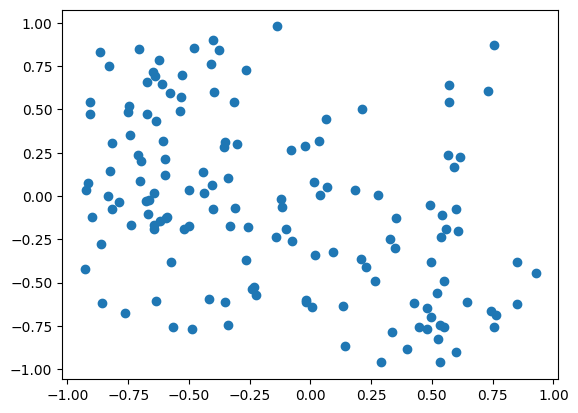

In [ ]:
plt.scatter(results[:,1], results[:,5])
#plt.scatter(target_train[:,1], target_train[:,5], marker='+')

In [ ]:
train_inp.mean()

0.05004962515314829

In [ ]:
loaded_model.get_smoothing_layer().maximum_res

0.1

In [ ]:
loaded_model.drop.rate

0.1

In [8]:
test_inp_multi = np.repeat(test_inp, 10, axis=0)
test_target_multi = np.repeat(target_test, 10, axis=0)